In [1]:
from IPython.display import clear_output
import PIL.Image
from io import BytesIO
import IPython.display
import time
import sys
sys.path.append('..')
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path

In [2]:
def get_class_dict():
    class_dict = {}
    file_list = sorted(Path('../data/hmdb51_splits').glob('*1.txt'))
    video_list = []
    for class_idx, f in enumerate(file_list):
        class_name = str(f).strip().split('/')[3][:-16]
        class_dict[class_idx] = class_name
    return class_dict

In [3]:
class_dict = get_class_dict()

In [4]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def array_to_image(a, fmt='jpeg'):
    #Create binary stream object
    f = BytesIO()
    
    #Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)
    
    return IPython.display.Image(data=f.getvalue())

In [5]:
from slidingwindow import load_model, construct_input, predict_input

In [6]:
model = load_model(
        modality="RGB",
        state_dict_file="../pretrained_chkpt/rgb_hmdb_split1.pt"
    )

In [7]:
def predict_window(frames, model, d2, class_dict):
    with torch.no_grad():
        batch = construct_input(frames)
        window_predictions = predict_input(model, batch)
        window_proba = F.softmax(window_predictions, dim=1)
        window_top_pred = window_proba.max(1)
        class_pred = class_dict[window_top_pred.indices.cpu().numpy()[0]]
        s = f"""class_pred: {class_pred}"""
        d2.update( IPython.display.HTML(s) )
        #print(("Class pred:{0} Class proba:{1}".format(
        #    window_top_pred.indices.cpu().numpy()[0],
        #    window_top_pred.values.cpu().numpy()[0])
        #))

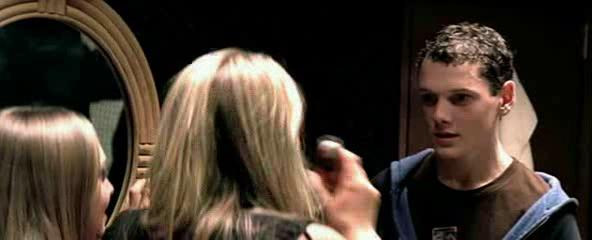

In [8]:
import cv2

import os

%matplotlib inline
from matplotlib import pyplot as plt

fps = 30
window_len = 60
eval_freq = 10
#cap = cv2.VideoCapture('./BATMAN_BEGINS_drink_h_nm_np1_fr_goo_9.avi')
cap = cv2.VideoCapture('/datadir/longvid/longvid.avi')
#cap.set(cv2.CAP_PROP_FPS, fps)
iter = 0
window_frame_list = []

d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)

while(True):
    ret, frame = cap.read()
    if not ret:
        break
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    rgb_pil_im = PIL.Image.fromarray(rgb_frame)
    im = array_to_image(rgb_frame)
    d.update(im)
    #time.sleep(1/fps)
    window_frame_list.append(rgb_pil_im)
    iter += 1
    if (len(window_frame_list) >= window_len) and (iter % eval_freq == 0):
        predict_window(window_frame_list, model, d2, class_dict)
        window_frame_list = window_frame_list[eval_freq:]

cap.release()

Performance testing

In [12]:
video_path = '/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/'

In [47]:
imgs = [video_path+'img_{:05}.jpg'.format(x) for x in range(1, 65)]

In [48]:
imgs

['/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/img_00001.jpg',
 '/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/img_00002.jpg',
 '/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/img_00003.jpg',
 '/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/img_00004.jpg',
 '/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/img_00005.jpg',
 '/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/img_00006.jpg',
 '/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/img_00007.jpg',
 '/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/img_00008.jpg',
 '/datadir/rawframes/brush_hair/Aussie_Brunette_Brushing_Long_Hair_brush_hair_u_nm_np1_ba_med_3/img_0000

In [49]:
from slidingwindow import load_frames

In [50]:
frames = load_frames(imgs)

In [23]:
frames

[<PIL.Image.Image image mode=RGB size=320x240 at 0x7FB78FE0CEB8>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7FB78FE0CE80>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7FB78FE0CB00>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7FB78FE0CCF8>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7FB78FE0C470>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7FB78FE0CBA8>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7FB78FE0CA90>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7FB78FE0C6A0>,
 <PIL.Image.Image image mode=RGB size=320x240 at 0x7FB78FE0CDA0>]

In [55]:
def predict_test(frames, model):
    with torch.no_grad():
        batch = construct_input(frames)
        window_predictions = predict_input(model, batch)
        window_proba = F.softmax(window_predictions, dim=1)
        window_top_pred = window_proba.max(1)
        #print(window_top_pred)

In [74]:
window_lens = [9, 32, 64]
for window_len in window_lens:
    test_frames = frames[:window_len]
    start = time.time()
    test_time = 60
    elapsed = 0
    inferences = 0
    while elapsed < test_time:
        predict_test(test_frames, model)
        inferences += 1
        elapsed = time.time() - start
    infpersec = inferences / elapsed
    print(str(window_len)+" input frames, ", "{0:.2f}".format(infpersec)+" inferences per second, inferences take ", "{0:.2f}".format(1000/infpersec), " ms")

9 input frames,  28.64 inferences per second, inferences take  34.91  ms
32 input frames,  11.48 inferences per second, inferences take  87.10  ms
64 input frames,  6.54 inferences per second, inferences take  153.00  ms
